In [26]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import layers, models, initializers
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import json
import pandas as pd
import os
import glob


# Get Data File

In [2]:
!wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
print("Dataset downloaded!")
print("Extracting data..")
!tar xzvf food-101.tar.gz > /dev/null 2>&1
print("Extraction done!")

--2024-03-25 23:34:11--  http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 2001:67c:10ec:36c2::178, 129.132.52.178
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|2001:67c:10ec:36c2::178|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data.vision.ee.ethz.ch/cvl/food-101.tar.gz [following]
--2024-03-25 23:34:12--  https://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|2001:67c:10ec:36c2::178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4996278331 (4.7G) [application/x-gzip]
Saving to: ‘food-101.tar.gz’

food-101.tar.gz     100%[===================>]   4.65G  5.63MB/s    in 24m 43s 

2024-03-25 23:58:55 (3.21 MB/s) - ‘food-101.tar.gz’ saved [4996278331/4996278331]

Dataset downloaded!
Extracting data..
Extraction done!


In [3]:
# img_height, img_width = 299, 299
# batch_size = 32
data_directory = 'food-101/images'  

# Load train and test JSON files
with open('food-101/meta/train.json') as f:
    train_data = json.load(f)

with open('food-101/meta/test.json') as f:
    test_data = json.load(f)

# Create DataFrame for train and test data
train_df = pd.DataFrame([(os.path.join(data_directory, f"{category}/{unique_id.split('/')[-1]}.jpg"), category) for category, unique_ids in train_data.items() for unique_id in unique_ids], columns=['filename', 'category'])
test_df = pd.DataFrame([(os.path.join(data_directory, f"{category}/{unique_id.split('/')[-1]}.jpg"), category) for category, unique_ids in test_data.items() for unique_id in unique_ids], columns=['filename', 'category'])


# Preprocess Image: tranform to numpy arrays 

In [4]:
def preprocess_image(image_path, target_size=(299, 299)):
    img = load_img(image_path, target_size=target_size)
    # Convert to RGB mode
    img = img.convert('RGB')
    # Convert to numpy array
    img_array = img_to_array(img)
    # Normalize pixel values to between 0 and 1
    img_array /= 255.
    return img_array

def preprocess_images_in_batches(image_paths, batch_size=1000, target_size=(299, 299), train = True):
    if train:
        dataset = 'train'
    else:
        dataset = 'test'
        
    num_images = len(image_paths)
    
    for i in range(0, num_images, batch_size):
        batch_paths = image_paths[i:i+batch_size]
        batch_images = [preprocess_image(image_path, target_size) for image_path in batch_paths]
        print(f"Processed {min(i+batch_size, num_images)} out of {num_images} images")
        np.save(f'Processed_images/{dataset}/inception_input_image_batch_{i}.npy', batch_images)
    


image_paths = train_df['filename'].tolist()
preprocess_images_in_batches(image_paths)

Processed 1000 out of 75750 images
Processed 2000 out of 75750 images
Processed 3000 out of 75750 images
Processed 4000 out of 75750 images
Processed 5000 out of 75750 images
Processed 6000 out of 75750 images
Processed 7000 out of 75750 images
Processed 8000 out of 75750 images
Processed 9000 out of 75750 images
Processed 10000 out of 75750 images
Processed 11000 out of 75750 images
Processed 12000 out of 75750 images
Processed 13000 out of 75750 images
Processed 14000 out of 75750 images
Processed 15000 out of 75750 images
Processed 16000 out of 75750 images
Processed 17000 out of 75750 images
Processed 18000 out of 75750 images
Processed 19000 out of 75750 images
Processed 20000 out of 75750 images
Processed 21000 out of 75750 images
Processed 22000 out of 75750 images
Processed 23000 out of 75750 images
Processed 24000 out of 75750 images
Processed 25000 out of 75750 images
Processed 26000 out of 75750 images
Processed 27000 out of 75750 images
Processed 28000 out of 75750 images
P

In [5]:
image_paths = test_df['filename'].tolist()
preprocess_images_in_batches(image_paths, train = False)

Processed 1000 out of 25250 images
Processed 2000 out of 25250 images
Processed 3000 out of 25250 images
Processed 4000 out of 25250 images
Processed 5000 out of 25250 images
Processed 6000 out of 25250 images
Processed 7000 out of 25250 images
Processed 8000 out of 25250 images
Processed 9000 out of 25250 images
Processed 10000 out of 25250 images
Processed 11000 out of 25250 images
Processed 12000 out of 25250 images
Processed 13000 out of 25250 images
Processed 14000 out of 25250 images
Processed 15000 out of 25250 images
Processed 16000 out of 25250 images
Processed 17000 out of 25250 images
Processed 18000 out of 25250 images
Processed 19000 out of 25250 images
Processed 20000 out of 25250 images
Processed 21000 out of 25250 images
Processed 22000 out of 25250 images
Processed 23000 out of 25250 images
Processed 24000 out of 25250 images
Processed 25000 out of 25250 images
Processed 25250 out of 25250 images


# Train latent vectors using Inception model

In [6]:
# include_top=False will discard avg_pool before prediction layer
inception = tf.keras.applications.inception_v3.InceptionV3(include_top=True, input_shape=(299, 299, 3))
inception = tf.keras.Model([inception.input], [inception.layers[-2].output]) # manually discard prediction layer

In [7]:
batch_size = 50

@tf.function
def calculate_latent_vectors(images_batch):
    latent_vectors = inception(images_batch)
    return latent_vectors
    
for i in range(0, 76000, 1000):
    images = np.load(f'Processed_images/train/inception_input_image_batch_{i}.npy')
    dataset = tf.data.Dataset.from_tensor_slices(images)
    images_batch = dataset.batch(batch_size)
    
    # Calculate latent vectors for each batch
    latent_vectors_list = []
    for batch in images_batch:
        latent_vectors = calculate_latent_vectors(batch)
        latent_vectors_list.append(latent_vectors)
    
    # Stack latent vectors from different batches
    latent_vectors_stacked = tf.concat(latent_vectors_list, axis=0)
    
    # Save latent vectors to a file
    np.save(f'latent_vectors/train/batch_{i}.npy', latent_vectors_stacked.numpy())
    print(f'finished batch {i}')

finished batch 0
finished batch 1000
finished batch 2000
finished batch 3000
finished batch 4000
finished batch 5000
finished batch 6000
finished batch 7000
finished batch 8000
finished batch 9000
finished batch 10000
finished batch 11000
finished batch 12000
finished batch 13000
finished batch 14000
finished batch 15000
finished batch 16000
finished batch 17000
finished batch 18000
finished batch 19000
finished batch 20000
finished batch 21000
finished batch 22000
finished batch 23000
finished batch 24000
finished batch 25000
finished batch 26000
finished batch 27000
finished batch 28000
finished batch 29000
finished batch 30000
finished batch 31000
finished batch 32000
finished batch 33000
finished batch 34000
finished batch 35000
finished batch 36000
finished batch 37000
finished batch 38000
finished batch 39000
finished batch 40000
finished batch 41000
finished batch 42000
finished batch 43000
finished batch 44000
finished batch 45000
finished batch 46000
finished batch 47000
finis

In [8]:
for i in range(0, 26000, 1000):
    images = np.load(f'Processed_images/test/inception_input_image_batch_{i}.npy')
    dataset = tf.data.Dataset.from_tensor_slices(images)
    images_batch = dataset.batch(batch_size)
    
    # Calculate latent vectors for each batch
    latent_vectors_list = []
    for batch in images_batch:
        latent_vectors = calculate_latent_vectors(batch)
        latent_vectors_list.append(latent_vectors)
    
    # Stack latent vectors from different batches
    latent_vectors_stacked = tf.concat(latent_vectors_list, axis=0)
    
    # Save latent vectors to a file
    np.save(f'latent_vectors/test/batch_{i}.npy', latent_vectors_stacked.numpy())
    print(f'finished batch {i}')

finished batch 0
finished batch 1000
finished batch 2000
finished batch 3000
finished batch 4000
finished batch 5000
finished batch 6000
finished batch 7000
finished batch 8000
finished batch 9000
finished batch 10000
finished batch 11000
finished batch 12000
finished batch 13000
finished batch 14000
finished batch 15000
finished batch 16000
finished batch 17000
finished batch 18000
finished batch 19000
finished batch 20000
finished batch 21000
finished batch 22000
finished batch 23000
finished batch 24000
finished batch 25000


# Train model using latent vectors

In [9]:
train_latent = []

for i in range(0, 76000, 1000):
    batch_filename = f'latent_vectors/train/batch_{i}.npy'
    latent_vectors_batch = np.load(batch_filename)
    train_latent.extend(latent_vectors_batch)
    
    
train_latent = np.array(train_latent)

In [42]:
train_labels = np.array(train_df['category'])

label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)

# one-hot encoding
y_train = tf.one_hot(train_labels_encoded, 101).numpy()


In [17]:
input_size = 2048
num_classes = 101
N_PIXELS = 299*299*3

model = models.Sequential()

model.add(layers.Dense(512, activation='sigmoid', use_bias=True, 
                       kernel_initializer=initializers.TruncatedNormal(stddev=N_PIXELS**-0.5)))

model.add(layers.Dropout(0.3))

model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)))

model.add(layers.Dropout(0.5))

model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))

model.add(layers.Dense(num_classes, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


# Combine input data and labels
all_data = np.hstack((train_latent, y_train))

# Shuffle the entire dataset
np.random.shuffle(all_data)

# Split the shuffled dataset into training and validation sets
train_data, val_data = train_test_split(all_data, test_size=0.2)

x_train = train_data[:, :-num_classes]
y_train = train_data[:, -num_classes:]

x_val = val_data[:, :-num_classes]
y_val = val_data[:, -num_classes:]

# Train the model with the shuffled data
model.fit(x_train, y_train, epochs=50, batch_size=32, validation_data=(x_val, y_val))



Epoch 1/50
1894/1894 [==============================] - 10s 5ms/step - loss: 3.4867 - accuracy: 0.2010 - val_loss: 2.6729 - val_accuracy: 0.3550
Epoch 2/50
1894/1894 [==============================] - 12s 6ms/step - loss: 2.7157 - accuracy: 0.3503 - val_loss: 2.4097 - val_accuracy: 0.4338
Epoch 3/50
1894/1894 [==============================] - 12s 7ms/step - loss: 2.5269 - accuracy: 0.3997 - val_loss: 2.2540 - val_accuracy: 0.4685
Epoch 4/50
1894/1894 [==============================] - 12s 6ms/step - loss: 2.4202 - accuracy: 0.4281 - val_loss: 2.2191 - val_accuracy: 0.4839
Epoch 5/50
1894/1894 [==============================] - 11s 6ms/step - loss: 2.3412 - accuracy: 0.4504 - val_loss: 2.1722 - val_accuracy: 0.4927
Epoch 6/50
1894/1894 [==============================] - 11s 6ms/step - loss: 2.2723 - accuracy: 0.4654 - val_loss: 2.1114 - val_accuracy: 0.5090
Epoch 7/50
1894/1894 [==============================] - 22s 11ms/step - loss: 2.2192 - accuracy: 0.4811 - val_loss: 2.1232 - val_a

In [18]:
model.save('food101_final_model.keras')

In [45]:
import joblib
joblib.dump(label_encoder, 'image_label_encoder.pkl')

['image_label_encoder.pkl']

In [20]:
test_latent = []

for i in range(0, 26000, 1000):
    batch_filename = f'latent_vectors/test/batch_{i}.npy'
    latent_vectors_batch = np.load(batch_filename)
    test_latent.extend(latent_vectors_batch)
    
    
test_latent = np.array(test_latent)

In [29]:
test_labels = np.array(test_df['category'])
test_labels_encoded = label_encoder.fit_transform(test_labels)
y_test = tf.one_hot(test_labels_encoded, 101).numpy()
test_data = np.hstack((test_latent, y_test))
np.random.shuffle(test_data)

x_test = test_data[:, :-num_classes]
y_test = test_data[:, -num_classes:]



In [30]:
predictions = model.predict(x_test)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_test, axis=1)

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)

790/790 [==============================] - 1s 948us/step


In [33]:
accuracy

0.6092277227722772

In [38]:
predict_labels = label_encoder.inverse_transform(predicted_labels)

In [39]:
true_labels_original

array(['paella', 'garlic_bread', 'bread_pudding', ..., 'lobster_bisque',
       'poutine', 'falafel'], dtype=object)

In [40]:
label_encoder

LabelEncoder()

In [13]:
train_image = np.load('Processed_images/train/inception_input_image_batch_0.npy')

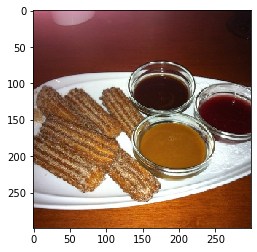

In [14]:
import matplotlib.pyplot
matplotlib.pyplot.rcParams["axes.grid"] = False  
matplotlib.pyplot.imshow(train_image[23][:, :, :])

In [ ]:
train_labels = np.array(train_df['category'])

label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)

NameError: name 'joblib' is not defined